# Music Ratings

In [1]:
import numpy as np
import pandas as pd

## 1. Data Loading

In [2]:
music_train=pd.read_csv("MusicRatingsTrain.csv", index_col = 0)
music_valA=pd.read_csv("MusicRatingsValidationA.csv", index_col = 0)
music_valB=pd.read_csv("MusicRatingsValidationB.csv", index_col = 0)
music_test=pd.read_csv("MusicRatingsTest.csv", index_col = 0)

## Part A

In [3]:
print('Number of Unique Songs in Training Dataset: ', len(np.unique(music_train['songID'])))
print('Number of Unique Users in Training Dataset: ', len(np.unique(music_train.index)))
print('Summary Statistics of Ratings:')
music_train[['rating']].describe()

Number of Unique Songs in Training Dataset:  807
Number of Unique Users in Training Dataset:  2421
Summary Statistics of Ratings:


,rating
count,245997.000000
mean,1.321962
std,0.459894
min,1.000000
25%,1.000000
50%,1.000000
75%,1.494918
max,4.768656


## Part B

### i)

In [4]:
print('Number of Total Parameters in Model: ', 807 + 2421) # number of users + number of songs
print('Number of Obervations to Train Model: ', music_train.shape[0])

Number of Total Parameters in Model:  3228
Number of Obervations to Train Model:  245997


## ii)

### ii.1 Convert dataframe to matrices

In [5]:
# Training Set
music_train = music_train.sort_values(by = ['userID', 'songID'])
music_train_df = music_train.pivot_table(index="userID", columns = "songID", values = "rating")
music_train_mat = music_train_df.to_numpy()
music_train_mat

# create a mask for the subset of the data
music_train_mask = ~np.isnan(music_train_mat)
np.sum(music_train_mask)

245997

Some *users* are not included in the validation or test set, due to the small set size. Therefore, we need to merge the validation and test set with the complete list of users.

In [6]:
user_df = music_train_df.reset_index()[['userID']]
user_df.head(3)

songID,userID
0,1
1,2
2,3


In [7]:
# Validation Set A

music_valA = music_valA.sort_values(by = ['userID', 'songID'])
music_valA_df = music_valA.pivot_table(index="userID", columns = "songID", values = "rating")
music_valA_df = pd.merge(user_df, music_valA_df.reset_index(), how = 'outer', on = 'userID')
music_valA_df = music_valA_df.set_index('userID')
music_valA_mat = music_valA_df.to_numpy()
music_valA_mat

# create a mask for the subset of the data
music_valA_mask = ~np.isnan(music_valA_mat)
np.sum(music_valA_mask)

# -------

# Validation Set B

music_valB = music_valB.sort_values(by = ['userID', 'songID'])
music_valB_df = music_valB.pivot_table(index="userID", columns = "songID", values = "rating")
music_valB_df = pd.merge(user_df, music_valB_df.reset_index(), how = 'outer', on = 'userID')
music_valB_df = music_valB_df.set_index('userID')
music_valB_mat = music_valB_df.to_numpy()
music_valB_mat

# create a mask for the subset of the data
music_valB_mask = ~np.isnan(music_valB_mat)
np.sum(music_valB_mask)

14471

In [8]:
# Test Set

music_test = music_test.sort_values(by = ['userID', 'songID'])
music_test_df = music_test.pivot_table(index="userID", columns = "songID", values = "rating")
music_test_df = pd.merge(user_df, music_test_df.reset_index(), how = 'outer', on = 'userID')
music_test_df = music_test_df.set_index('userID')
music_test_mat = music_test_df.to_numpy()
music_test_mat

# create a mask for the subset of the data
music_test_mask = ~np.isnan(music_test_mat)
np.sum(music_test_mask)

14471

In [9]:
music_test.head(3)

,songID,rating,songName,year,artist,genre
userID,,,,,,
1,7,1.989836,Halo,2008,Beyonce,Pop
1,753,1.784426,Bitter Sweet Symphony,1997,The Verve,Pop
2,72,1.784426,Teeth,2009,Lady GaGa,Pop


### ii.2 Basic Analysis: BiScaler Centering

In [10]:
from fancyimpute import BiScaler

In [15]:
music_biscaler = BiScaler(scale_rows=False, scale_columns=False, verbose=False)
music_train_mat_centered = music_biscaler.fit_transform(music_train_mat)

In [12]:
import copy #fill NaN values with 0
music_centered_0 = copy.copy(music_train_mat_centered)
music_centered_0[np.isnan(music_centered_0)]=0
music_centered_0.shape

(2421, 807)

In [13]:
music_BiScaler_filled = music_biscaler.inverse_transform(music_centered_0) #Sophea fix: what does this do?
music_BiScaler_filled

array([[1.34450503, 1.51787035, 1.69263387, ..., 1.55709616, 1.41842513,
        1.40129053],
       [1.4868899 , 1.98983574, 1.83501874, ..., 1.69948103, 1.56081   ,
        1.5436754 ],
       [0.98649909, 1.15986441, 1.33462793, ..., 1.19909023, 1.0604192 ,
        1.0432846 ],
       ...,
       [1.10753272, 1.28089804, 1.45566156, ..., 1.32012386, 1.18145283,
        1.16431823],
       [1.01559836, 1.18896367, 1.3637272 , ..., 1.22818949, 1.08951846,
        1.07238386],
       [1.03554825, 1.49491787, 1.49491787, ..., 1.24813938, 1.10946835,
        1.09233375]])

### ii. Top Three Songs

In [14]:
# Access the alpha (row_mean) and beta (column) values
# print(music_biscaler.row_means)
# print(music_biscaler.column_means)

top_songs = pd.DataFrame(music_biscaler.column_means)
top_songs.index = np.arange(1, len(top_songs) + 1)
top_songs = top_songs.nlargest(3, columns = 0)
top_songs.merge(music_train, left_index = True, right_on = 'songID').groupby('songID').first()

,0,rating,songName,year,artist,genre
songID,,,,,,
26,2.137063,3.451920,Undo,2001,Bjork,Rock
54,2.157841,3.451920,You're The One,1990,Dwight Yoakam,Country
439,2.038437,2.774262,Secrets,2009,OneRepublic,Rock


The three most popular song IDs, songs, and artists are displayed in the above dataframe. The song indices are 26, 54, and 439. This answers refers to the 3 greatest beta_j coefficients in the model.

### iii. Top Three Users

In [15]:
top_users = pd.Series(music_biscaler.row_means).nlargest(3) #users
print('Most Enthused User IDs:\n', top_users)

Most Enthused User IDs:
 1539    0.967014
837     0.814727
1568    0.794237
dtype: float64


### iv. Out-of-Sample Performance on Test Set

In [16]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))

def masked_mse(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(masked_diff ** 2)

def OSR2(mse_model, mse_baseline):
    return 1 - mse_model/mse_baseline

In [17]:
music_test_mae = masked_mae(music_test_mat, music_BiScaler_filled, music_test_mask)
print("Biscale MAE %s " % (music_test_mae/4)) #Note that we normalize MAE and RMSE by the scale of the ratings, which is 5 - 1 = 4.

music_test_mse = masked_mse(music_test_mat, music_BiScaler_filled, music_test_mask)
print("Biscale RMSE %s " % (np.sqrt(music_test_mse)/4))

baseline_pred = np.mean(music_train['rating'])
baseline_model = baseline_pred*np.ones(music_train_mat.shape)
baseline_mse = masked_mse(music_test_mat, baseline_model, music_test_mask)
print("Biscale R2 %s" % OSR2(music_test_mse, baseline_mse))

Biscale MAE 0.0747571775133017 
Biscale RMSE 0.0985693901114982 
Biscale R2 0.2702373901935097


## Part C

## i. 

In [18]:
m = 807 # songs
n = 2421 # users
print('Total Number of Parameters including Low-Rank Model: k * 3228 +', m + n)
print('Number of Obervations to Train Model: ', music_train.shape[0])

Total Number of Parameters including Low-Rank Model: k * 3228 + 3228
Number of Obervations to Train Model:  245997


## ii.

In [19]:
from fancyimpute import SoftImpute

music_soft_imputer = SoftImpute(max_rank=5, verbose=True)
music_centered_filled = music_soft_imputer.fit_transform(music_train_mat_centered)

[SoftImpute] Max Singular Value of X_init = 35.403705
[SoftImpute] Iter 1: observed MAE=0.276595 rank=5
[SoftImpute] Iter 2: observed MAE=0.272222 rank=5
[SoftImpute] Iter 3: observed MAE=0.269771 rank=5
[SoftImpute] Iter 4: observed MAE=0.268023 rank=5
[SoftImpute] Iter 5: observed MAE=0.266677 rank=5
[SoftImpute] Iter 6: observed MAE=0.265593 rank=5
[SoftImpute] Iter 7: observed MAE=0.264694 rank=5
[SoftImpute] Iter 8: observed MAE=0.263930 rank=5
[SoftImpute] Iter 9: observed MAE=0.263269 rank=5
[SoftImpute] Iter 10: observed MAE=0.262688 rank=5
[SoftImpute] Iter 11: observed MAE=0.262173 rank=5
[SoftImpute] Iter 12: observed MAE=0.261714 rank=5
[SoftImpute] Iter 13: observed MAE=0.261302 rank=5
[SoftImpute] Iter 14: observed MAE=0.260932 rank=5
[SoftImpute] Iter 15: observed MAE=0.260600 rank=5
[SoftImpute] Iter 16: observed MAE=0.260301 rank=5
[SoftImpute] Iter 17: observed MAE=0.260029 rank=5
[SoftImpute] Iter 18: observed MAE=0.259782 rank=5
[SoftImpute] Iter 19: observed MAE=0.

In [20]:
music_centered_filled

array([[-0.06105436, -0.12093986, -0.19588552, ..., -0.16762857,
         0.02217673, -0.0568743 ],
       [ 0.07227458,  0.32958053, -0.36096664, ...,  0.05217069,
         0.16989318,  0.18727827],
       [-0.0321835 , -0.01191827,  0.08313618, ...,  0.01711593,
        -0.00265758,  0.01637631],
       ...,
       [-0.02714709, -0.17576023,  0.05838181, ...,  0.17177322,
        -0.11512138,  0.06901824],
       [ 0.09173572, -0.0796666 , -0.27515093, ..., -0.04609432,
         0.11200354, -0.17551012],
       [-0.03976306,  0.28600431,  0.11124078, ...,  0.02673966,
         0.00703386, -0.04294993]])

In [21]:
music_SoftImpute_filled = music_biscaler.inverse_transform(music_centered_filled)
music_SoftImpute_filled = np.clip(music_SoftImpute_filled, 1, 5)
music_SoftImpute_filled

array([[1.28345067, 1.39693048, 1.49674834, ..., 1.38946759, 1.44060186,
        1.34441623],
       [1.55916447, 1.98983574, 1.47405209, ..., 1.75165172, 1.73070318,
        1.73095367],
       [1.        , 1.14794614, 1.41776411, ..., 1.21620616, 1.05776162,
        1.05966091],
       ...,
       [1.08038564, 1.10513781, 1.51404337, ..., 1.49189708, 1.06633144,
        1.23333647],
       [1.10733408, 1.10929707, 1.08857627, ..., 1.18209517, 1.201522  ,
        1.        ],
       [1.        , 1.49491787, 1.49491787, ..., 1.27487904, 1.11650221,
        1.04938383]])

In [22]:
music_test_mae = masked_mae(music_test_mat, music_SoftImpute_filled, music_test_mask)
print("SoftImpute MAE %s " % (music_test_mae/4)) #Note that we normalize MAE and RMSE by the scale of the ratings, which is 4.768656 - 1.

music_test_mse = masked_mse(music_test_mat, music_SoftImpute_filled, music_test_mask)
print("SoftImpute RMSE %s " % (np.sqrt(music_test_mse)/4))

baseline_pred = np.mean(music_train['rating'])
baseline_model = baseline_pred*np.ones(music_train_mat.shape)
baseline_mse = masked_mse(music_test_mat, baseline_model, music_test_mask)
print("SoftImpute R2 %s" % OSR2(music_test_mse, baseline_mse))

SoftImpute MAE 0.07090405508194468 
SoftImpute RMSE 0.09656562777134375 
SoftImpute R2 0.29960569586445585


### Cross-validation to choose the best number of Archetypal Users

In [23]:
import timeit
start = timeit.default_timer()

music_valA_mae_lst = []
for i in range(20):
    param_cv = i+1
    music_soft_imputer_cv = SoftImpute(max_rank=param_cv, verbose=False)
    music_centered_filled_cv = music_soft_imputer_cv.fit_transform(music_train_mat_centered)
    music_filled_cv = music_biscaler.inverse_transform(music_centered_filled_cv)
    music_filled_cv = np.clip(music_filled_cv, 1, 5)
    music_valA_mae_cv = masked_mse(music_valA_mat, music_filled_cv, music_valA_mask)
    music_valA_mae_lst.append(music_valA_mae_cv)
    print('iter %s - Validation MAE %s' % (param_cv, music_valA_mae_cv))
    
stop = timeit.default_timer()
print('Time: ', stop - start) #Took 7 minutes to run

iter 1 - Validation MAE 0.14939931545451687
iter 2 - Validation MAE 0.14798156932661113
iter 3 - Validation MAE 0.14867867314542774
iter 4 - Validation MAE 0.14770607070241668
iter 5 - Validation MAE 0.15070705009095883
iter 6 - Validation MAE 0.15040976797135666
iter 7 - Validation MAE 0.15225942257471425
iter 8 - Validation MAE 0.15459409308445224
iter 9 - Validation MAE 0.15677194070373965
iter 10 - Validation MAE 0.15665071957052834
iter 11 - Validation MAE 0.16217248308731627
iter 12 - Validation MAE 0.16438387256052828
iter 13 - Validation MAE 0.16474520021800787
iter 14 - Validation MAE 0.1699229040805542
iter 15 - Validation MAE 0.1720410027015302
iter 16 - Validation MAE 0.17599756490744467
iter 17 - Validation MAE 0.17468166235123264
iter 18 - Validation MAE 0.17680722151571418
iter 19 - Validation MAE 0.18004793219733525
iter 20 - Validation MAE 0.18274626760180057
Time:  546.5305814500025


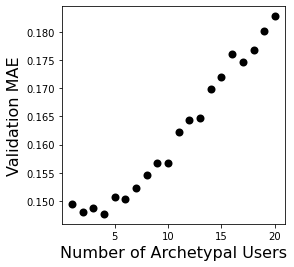

Optimial k Value:  4


In [24]:
import matplotlib.pyplot as plt
x = range(1,21)
y = music_valA_mae_lst
plt.figure(figsize=(4, 4))
plt.scatter(x, y, linewidth=2, color='black')
plt.xlabel('Number of Archetypal Users', fontsize=16)
plt.ylabel('Validation MAE', fontsize=16)
plt.show()
print('Optimial k Value: ', np.argmin(y)+1)

Cross-validation shows that the MAE is minimized when k, the number of archetypes, is set to 4. This is also shown in the plot above. The corresponding minimum MAE is 0.14770607070241668.

## iii. Collaborative Filtering Model

In [25]:
music_soft_imputer = SoftImpute(max_rank=4, verbose=False) #use the best k from part ii
music_centered_filled = music_soft_imputer.fit_transform(music_train_mat_centered) #initiliazed music_train_mat_centered with BiScaler
music_filled_matrix = music_biscaler.inverse_transform(music_centered_filled)
music_filled_matrix = np.clip(music_filled_matrix, 1, 5)

#### 1. Collaborative Filtering. Performance on Test Set

In [26]:
music_test_mae = masked_mae(music_test_mat, music_filled_matrix, music_test_mask)
print("CF MAE %s " % (music_test_mae/4)) #Note that we normalize MAE and RMSE by the scale of the ratings, which is 4.768656 - 1.

music_test_mse = masked_mse(music_test_mat, music_filled_matrix, music_test_mask)
print("CF RMSE %s " % (np.sqrt(music_test_mse)/4))

baseline_pred = np.mean(music_train['rating'])
baseline_model = baseline_pred*np.ones(music_train_mat.shape)
baseline_mse = masked_mse(music_test_mat, baseline_model, music_test_mask)
print("CF OR2 %s" % OSR2(music_test_mse, baseline_mse))

CF MAE 0.07063690502316015 
CF RMSE 0.09598278651787194 
CF OR2 0.3080349218852486


In [27]:
baseline_pred

1.3219620891310984

# Part D

### i. Two More Models

#### 2. Linear Regression

In [28]:
music_train['genre'] = music_train.genre.astype('category')
music_valA['genre'] = music_valA.genre.astype('category')
music_valB['genre'] = music_valB.genre.astype('category')
music_test['genre'] = music_test.genre.astype('category')

music_train['year'] = music_train.year.astype('category')
music_valA['year'] = music_valA.year.astype('category')
music_valB['year'] = music_valB.year.astype('category')
music_test['year'] = music_test.year.astype('category')

In [29]:
# music_train.reset_index()

In [30]:
import statsmodels.formula.api as smf
my_formula = "rating ~ genre + year"
music_ols = smf.ols(formula=my_formula, data=music_train.reset_index())
res = music_ols.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     261.6
Date:                Thu, 29 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:23:34   Log-Likelihood:            -1.5373e+05
No. Observations:              245997   AIC:                         3.075e+05
Df Residuals:                  245963   BIC:                         3.079e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.0937    

In [31]:
test_pred_ols = res.predict(music_test.reset_index())
test_mae_ols = np.mean(np.abs(music_test_mat[music_test_mask] - test_pred_ols))
print("MAE %s " % (test_mae_ols/4)) #Note that we normalize MAE and RMSE by the scale of the ratings, which is 5-1=4.

test_mse_ols = np.mean((music_test_mat[music_test_mask] - test_pred_ols)**2)
print("RMSE %s " % (np.sqrt(test_mse_ols)/4))

print("OSR2 %s " % OSR2(test_mse_ols, baseline_mse))

MAE 0.09235568153592498 
RMSE 0.11312545968408344 
OSR2 0.038790215131095374 


#### 3. Random Forests

In [32]:
from sklearn.ensemble import RandomForestRegressor

import timeit
start = timeit.default_timer()

# X_train = music_train.drop(columns = ["songID","rating", 'songName', 'artist'])
X_train = music_train[['year', 'genre']]
X_train = pd.get_dummies(X_train)
y_train = music_train["rating"]
rf = RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators = 500, random_state=88, verbose=2)
rf.fit(X_train, y_train)

stop = timeit.default_timer()
print('Time: ', stop - start)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.4min finished


In [33]:
test_pred_rf = rf.predict(pd.get_dummies(music_test[['year', 'genre']]))
test_mae_rf = np.mean(np.abs(music_test_mat[music_test_mask] - test_pred_rf))
print("MAE %s " % (test_mae_rf/4)) #Note that we normalize MAE and RMSE by the scale of the ratings, which is 5-1=4.

test_mse_rf = np.mean((music_test_mat[music_test_mask] - test_pred_rf)**2)
print("RMSE %s " % (np.sqrt(test_mse_rf)/4))

print("OSR2 %s " % OSR2(test_mse_rf, baseline_mse))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


MAE 0.09152666687515922 
RMSE 0.11243412826498947 
OSR2 0.050502592495190735 


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.7s finished


## ii. Blending

Here, I compute the predictions of the three models (Collaborative Filtering, OLS, Random Forests) on Validation Set B, and put them into a dataframe with Validation B's ratings. Then I train a linear regression model to blend the 3 model's predicted ratings. I name the fitted model valB_blending. Finally, to evaluate the blended model's performance on the test set, I make a dataframe of the three models individually on the test set, and combine the predictions with the model valB_blending.

In [34]:
pd.get_dummies(music_valB[['year', 'genre']])

,year_1975,year_1976,year_1978,year_1979,year_1985,year_1986,year_1987,year_1988,year_1990,year_1991,...,year_2008,year_2009,year_2010,genre_Country,genre_Electronic,genre_Folk,genre_Pop,genre_Rap,genre_RnB,genre_Rock
userID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2421,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [35]:
valB_pred_blending = pd.DataFrame(data = music_filled_matrix[music_valB_mask]).rename(columns = {0: 'cf'})
valB_pred_blending['ols'] = res.predict(music_valB[['year', 'genre']]).values
valB_pred_blending['rf'] = rf.predict(pd.get_dummies(music_valB[['year', 'genre']]))
valB_pred_blending['rating'] = music_valB['rating'].values

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished


In [36]:
valB_pred_blending

,cf,ols,rf,rating
0,2.305456,1.328672,1.322405,1.989836
1,1.498923,1.346034,1.359284,1.000000
2,1.683799,1.361723,1.337721,1.784426
3,1.482973,1.373052,1.315066,1.000000
4,1.636671,1.281161,1.239557,1.000000
...,...,...,...,...
14466,1.341361,1.313628,1.313691,1.000000
14467,1.190828,1.207557,1.220499,1.000000
14468,1.460254,1.278295,1.297004,1.000000
14469,1.670098,1.381367,1.379889,1.989836


In [37]:
valB_blending_model = smf.ols(formula='rating ~ cf + ols + rf - 1', data=valB_pred_blending)
valB_blending = valB_blending_model.fit()
print(valB_blending.summary())

                                 OLS Regression Results                                
Dep. Variable:                 rating   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                          6.024e+04
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        13:24:59   Log-Likelihood:                         -6645.7
No. Observations:               14471   AIC:                                  1.330e+04
Df Residuals:                   14468   BIC:                                  1.332e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [38]:
blend_test = pd.DataFrame(data = music_filled_matrix[music_test_mask]).rename(columns = {0: 'cf'})
blend_test['ols'] = test_pred_ols.values
blend_test['rf'] = test_pred_rf
blend_test['rating'] = music_test['rating'].values
blend_test.head()

,cf,ols,rf,rating
0,2.041785,1.313628,1.313691,1.989836
1,1.746666,1.408423,1.440233,1.784426
2,1.610096,1.381367,1.379889,1.784426
3,1.452155,1.132071,1.131495,1.000000
4,1.700693,1.310684,1.308723,1.784426


In [39]:
valB_blend_on_test = valB_blending.predict(blend_test)
test_mae_blend = np.mean(np.abs(music_test_mat[music_test_mask] - valB_blend_on_test))
print("MAE %s " % (test_mae_blend/4)) #Note that we normalize MAE and RMSE by the scale of the ratings, which is 5-1=4.

test_mse_blend = np.mean((music_test_mat[music_test_mask] - valB_blend_on_test)**2)
print("RMSE %s " % (np.sqrt(test_mse_blend)/4))

print("OSR2 %s " % OSR2(test_mse_blend, baseline_mse))

MAE 0.07186751421722393 
RMSE 0.09491430112521926 
OSR2 0.32335515456393227 


#### Yes, the blending added predictive performance if measuring by OSR2. The best OSR2 of an individual model was from the collaborative filtering model, 0.308 -- this model used data from each (user, song) pair. With blending, the OSR2 increased to 0.323. However, the MAE slightly increased and the RMSE barely decreased, so by those metrics, the features associated with songs did not add a lot of predictive power on top of the collaborative filtering model.